# Trained vs Untrained Model
- out["reward"] : The completion time of all scheduling operations.
- Model : L2DPPOModel
- Policy : L2DPolicy4PPO

In [ ]:
import time

from rl4co.envs.scheduling.djssp.env import DJSSPEnv
from rl4co.models import L2DPolicy, L2DModel
from rl4co.utils import RL4COTrainer
import gc
from rl4co.envs import JSSPEnv
from rl4co.models.zoo.l2d.model import L2DPPOModel
from rl4co.models.zoo.l2d.policy import L2DPolicy4PPO
from torch.utils.data import DataLoader
import json
import os
%load_ext autoreload
%autoreload 2
generator_params = {
"num_jobs" : 6 ,
"num_machines": 6 ,
"min_processing_time": 1 ,
"max_processing_time": 99 ,
"mtbf" : 17 ,
"mttr" : 4
}
env = DJSSPEnv(generator_params=generator_params,
_torchrl_mode=True,
stepwise_reward=True)


In [ ]:
import torch
if torch.cuda.is_available():
    accelerator = "gpu"
    batch_size = 4
    train_data_size = 2_000
    embed_dim = 128
    num_encoder_layers = 4
else:
    accelerator = "cpu"
    batch_size = 2
    train_data_size = 1_000
    embed_dim = 64
    num_encoder_layers = 2

In [ ]:
# Policy: neural network, in this case with encoder-decoder architecture
policy = L2DPolicy4PPO(
    embed_dim=embed_dim,
    num_encoder_layers=num_encoder_layers,
    env_name="djsp",
    het_emb=False
)


In [ ]:
model = L2DPPOModel(
    env=env,
    policy=policy,
    batch_size=32,
    train_data_size=train_data_size,
    val_data_size=1_000,
    optimizer_kwargs={"lr": 1e-4}
)

## Scheduling of the `untrained model`

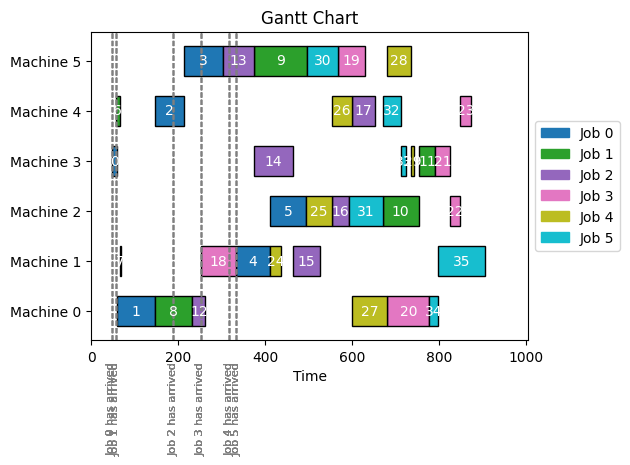

In [28]:
td = env.reset(batch_size=[1])
policy = policy.to("cpu")
out = model.policy.generate(td.clone(), env=env, phase="test", decode_type="multistart_sampling", num_starts=100, select_best=True)


In [29]:
td["proc_times"]

tensor([[[  0.0000,  79.7323,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,  80.6445,   0.0000,   0.0000,   0.0000,  30.1164,   0.0000,
            0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  95.7126,
            0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  73.4529,
            0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  20.5327,
            0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,  78.6627,   0.0000,   0.0000,
            2.9991,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,  63.5962,   0.0000,   0.0000,  74.1801,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000,  24.7861,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          107.8335],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  82.4135,   0.0000,
            0.0000,   0.0000,   0.0000,  82.7636,   0.0000,   0.0000,   0.0000

## Training the model
- For computational time considerations, the maximum epochs and batch sizes were kept low.

In [30]:
CHECKPOINT_PATH = "last.ckpt"
device = "cuda" if torch.cuda.is_available() else "cpu"
try:
    model = L2DPPOModel.load_from_checkpoint(CHECKPOINT_PATH)
except FileNotFoundError:

    trainer = RL4COTrainer(
        max_epochs=1,
        accelerator=accelerator,
        devices=1,
        logger=None,
    )

    trainer.fit(model)
finally:
    model = model.to(device)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Overriding gradient_clip_val to None for 'automatic_optimization=False' models
C:\Users\soner\anaconda3\envs\reinforce\Lib\site-packages\lightning\pytorch\utilities\parsing.py:45: Attribute 'policy' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['policy'])`.

Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

## Scheduling of the `trained model`

In [ ]:
out = model.policy.generate(td.clone(), env=env, phase="test", decode_type="multistart_sampling", num_starts=100, select_best=True)

## Exact finishing time 

In [ ]:
# Finish time of the scheduling
out["reward"]

# Test on Taillard Benchmark

In [ ]:
! git clone https://github.com/tamy0612/JSPLIB.git


In [ ]:
import json
import os


def prepare_taillard_data(nj, nm):
    # Target folder for Taillard instances
    fp = f"taillard/{nj}x{nm}"

    if not os.path.exists(fp):
        os.makedirs(fp)

    # Load the JSON file
    with open('JSPLIB/instances.json', 'r') as file:
        data = json.load(file)

    # Filter Taillard instances with matching jobs and machines
    instances = [x for x in data if "ta" in x["name"] and x["jobs"] == nj and x["machines"] == nm]
    print(f"Found {len(instances)} instances for {nj} jobs and {nm} machines")

    if not instances:
        raise FileNotFoundError(f"No matching Taillard instances found for {nj}x{nm}")

    # Copy files and validate
    for instance in instances:
        source_path = os.path.join("JSPLIB", instance['path'])
        target_path = os.path.join(fp, f"{instance['name']}.txt")

        # Check if the source file exists
        if os.path.exists(source_path):
            print(f"Copying {source_path} to {target_path}")
            os.system(f"cp {source_path} {target_path}")
        else:
            print(f"Warning: Source file {source_path} does not exist")

    # Verify if files were copied
    files_in_target = os.listdir(fp)
    assert len(files_in_target) > 0, f"No files copied to {fp}. Check source paths."
    print(f"Successfully prepared {len(files_in_target)} files in {fp}")

In [ ]:
import gc

device = "cuda" if torch.cuda.is_available() else "cpu"

# path to taillard instances
FILE_PATH = "taillard/{nj}x{nm}"

results = {}
instance_types = [(15, 15), (20, 15), (20, 20), (30, 15), (30, 20)]

for instance_type in instance_types:
    print("------------")
    nj, nm = instance_type
    prepare_taillard_data(nj, nm)
    dataset = env.dataset(batch_size=[10], phase="test", filename=FILE_PATH.format(nj=nj, nm=nm))
    dl = DataLoader(dataset, batch_size=5, collate_fn=dataset.collate_fn)
    rewards = []

    for batch in dl:
        td = env.reset(batch).to(device)
        # use policy.generate to avoid grad calculations which can lead to oom
        out = model.policy.generate(td, env=env, phase="test", decode_type="multistart_sampling", num_starts=100, select_best=True)
        rewards.append(out["reward"])

    reward = torch.cat(rewards, dim=0).mean().item()
    results[instance_type] = reward

    print("Done evaluating instance type %s with reward %s" % (instance_type, reward))

    # avoid ooms due to cache not being cleared
    model.rb.empty()
    gc.collect()
    torch.cuda.empty_cache()